# FBB Not enough interpretation! 
# FBB you should remove my instruction cells: this should be your notebook, with your description of the exercise as a header, and your code and description of the code, and plots, and explaining why you do what you do
# without a discussion I have no idea of you deapth of understanding of the inference you re doing

# you MUST  and decribe with captions your figure to show that you are understanding what you are doing, and to allow the reader to understand the notebook without having to read the code. Just stating what is plotted is not quit enought. The notebook is a "presentation". The most important part of the presentation is how you show me how the data take to your conclusions.

# In the conclusions, though you have some good points, you missed the covariance of race and income which invalidates the first part of the analysis (and perhaps the second too)

# look for more comments int he cells containing FBB


## Assignment 2: Gender Income Gap

This notebook presents a an analysis of the gender income gap based on the US Census data from

http://www.census.gov/hhes/www/cpstables/032015/perinc/pinc03_000.htm

We will be be using the data to try to build a -morally questionable- model to support the decission on "what to offer to a woman job candidate, given what is offered to a man for the same job?"

This notebook is based on the skeleton notebook from FBB:

https://github.com/fedhere/PUI2016_fb55/blob/master/HW5_fb55/genderIncomeBias.ipynb

In [182]:
# Standard imports to work with datasets, plots, distributions, etc.
import pylab as pl
import pandas as pd
import numpy as np
import os
import json
import requests
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import *

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)

url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
pl.rcParams.update(data)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
# Defining structures and getting the data
# We will create two dictionaries to store all data (allmen and allwomen)

# Base URL for the data store
url = "http://cosmo.nyu.edu/~fb55/PUI2016/data/"

# File Coding
# 08_2 are male,
# 08_3 are female,
# _1_1 is all ethnicities
# _1_4 is white
# _1_6 is black
# _1_8 is asian
# _1_9 is hispanic

# Using the pandas read from excel method to create the dataframes
# Will read directly the xls files, skipping the first eight rows

dfMenAll = pd.read_excel(url + 'pinc08_2_1_1.xls', skiprows=[0,1,2,3,4,5,6,7,8])
dfMenWhite = pd.read_excel(url + 'pinc08_2_1_4.xls', skiprows=[0,1,2,3,4,5,6,7,8])
dfMenBlack = pd.read_excel(url + 'pinc08_2_1_6.xls', skiprows=[0,1,2,3,4,5,6,7,8])
dfMenHispanic = pd.read_excel(url + 'pinc08_2_1_8.xls', skiprows=[0,1,2,3,4,5,6,7,8])
dfMenAsian = pd.read_excel(url + 'pinc08_2_1_9.xls', skiprows=[0,1,2,3,4,5,6,7,8])

dfWomenAll = pd.read_excel(url + 'pinc08_3_1_1.xls', skiprows=[0,1,2,3,4,5,6,7,8])
dfWomenWhite = pd.read_excel(url + 'pinc08_3_1_4.xls', skiprows=[0,1,2,3,4,5,6,7,8])
dfWomenBlack = pd.read_excel(url + 'pinc08_3_1_6.xls', skiprows=[0,1,2,3,4,5,6,7,8])
dfWomenHispanic = pd.read_excel(url + 'pinc08_3_1_8.xls', skiprows=[0,1,2,3,4,5,6,7,8])
dfWomenAsian= pd.read_excel(url + 'pinc08_3_1_9.xls', skiprows=[0,1,2,3,4,5,6,7,8])

allmales = {'all':dfMenAll, 'white':dfMenWhite, 'black':dfMenBlack, 'hispanic':dfMenHispanic, 'asian':dfMenAsian}
allfemales = {'all':dfWomenAll, 'white':dfWomenWhite, 'black':dfWomenBlack, 
             'hispanic':dfWomenHispanic, 'asian':dfWomenAsian}

allfemales['all'].head()

,Characteristic,Total with Income,"$1 to $2,499 or loss","$2,500 to $4,999","$5,000 to $7,499","$7,500 to $9,999","$10,000 to $12,499","$12,500 to $14,999","$15,000 to $17,499","$17,500 to $19,999",...,"$92,500 to $94,999","$95,000 to $97,499","$97,500 to $99,999","$100,000 and over",Median income,Unnamed: 44,Mean income,Unnamed: 46,Gini ratio,Unnamed: 48
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Value\n(Dol.),Standard\nerror (Dol.),Value\n(Dol.),Standard\nerror (Dol.),Ratio,Standard\nerror
1,....Total,109956.0,7590.0,4298.0,5557.0,7874.0,8052.0,5720.0,6768.0,4377.0,...,167.0,285.0,184.0,4442.0,22063,137,31968,250,0.495,0.0025
2,Earnings,74545.0,4198.0,3118.0,3269.0,2662.0,4579.0,1994.0,4134.0,2585.0,...,60.0,236.0,127.0,3535.0,27736,364,36189,307,0.466,0.0032
3,..Wages and Salary,71220.0,3835.0,2954.0,3005.0,2411.0,4309.0,1941.0,3908.0,2484.0,...,61.0,233.0,126.0,3370.0,28402,379,36412,316,0.461,0.0032
4,..Nonfarm Self-Employment,4694.0,1282.0,288.0,410.0,253.0,388.0,84.0,265.0,126.0,...,0.0,0.0,0.0,127.0,10732,399,20942,1123,0.65,0.0162


In [27]:
# the files are a bit of a mess! 
print (allfemales['all'].columns)

# just run this cell to get an idea of the data
#for k,v in allfemales.items():
#    print("#####", k)
#    print(v.describe())
#for k,v in allmales.items():
#    print("#####", k)
#    print(v.describe())


Index([      u'Characteristic',    u'Total with Income',
       u'$1 to $2,499 or loss',     u'$2,500 to $4,999',
           u'$5,000 to $7,499',     u'$7,500 to $9,999',
         u'$10,000 to $12,499',   u'$12,500 to $14,999',
         u'$15,000 to $17,499',   u'$17,500 to $19,999',
         u'$20,000 to $22,499',   u'$22,500 to $24,999',
         u'$25,000 to $27,499',   u'$27,500 to $29,999',
         u'$30,000 to $32,499',   u'$32,500 to $34,999',
         u'$35,000 to $37,499',   u'$37,500 to $39,999',
         u'$40,000 to $42,499',   u'$42,500 to $44,999',
         u'$45,000 to $47,499',   u'$47,500 to $49,999',
         u'$50,000 to $52,499',   u'$52,500 to $54,999',
         u'$55,000 to $57,499',   u'$57,500 to $59,999',
         u'$60,000 to $62,499',   u'$62,500 to $64,999',
         u'$65,000 to $67,499',   u'$67,500 to $69,999',
         u'$70,000 to $72,499',   u'$72,500 to $74,999',
         u'$75,000 to $77,499',   u'$77,500 to $79,999',
         u'$80,000 to $82,499',

In [28]:
# there are a lot of non-real values that make the analysis hard.
# the ugly loops below will help you clean up 
# CHALLENGE: can you do better and to it in a more pythonic way 
#            without using loops? 
#NOTE: this only will work if the data is store how I suggested. 
# you are welcome to find your own solution though.

for gender in [allmales, allfemales]:
    for k in gender:
        # find non real values in the dataframe with applymap
        isreal  = gender[k].applymap(np.isreal)
        for c in gender[k].columns :
            #i f some but not all values in column are real
            #replace the non real ones
            if isreal.sum()[c] > 0 and \
            isreal.sum()[c] < gender[k].shape[0]:
                gender[k][c][~isreal[c]] =  np.nan
                gender[k][c] = gender[k][c].astype(float)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


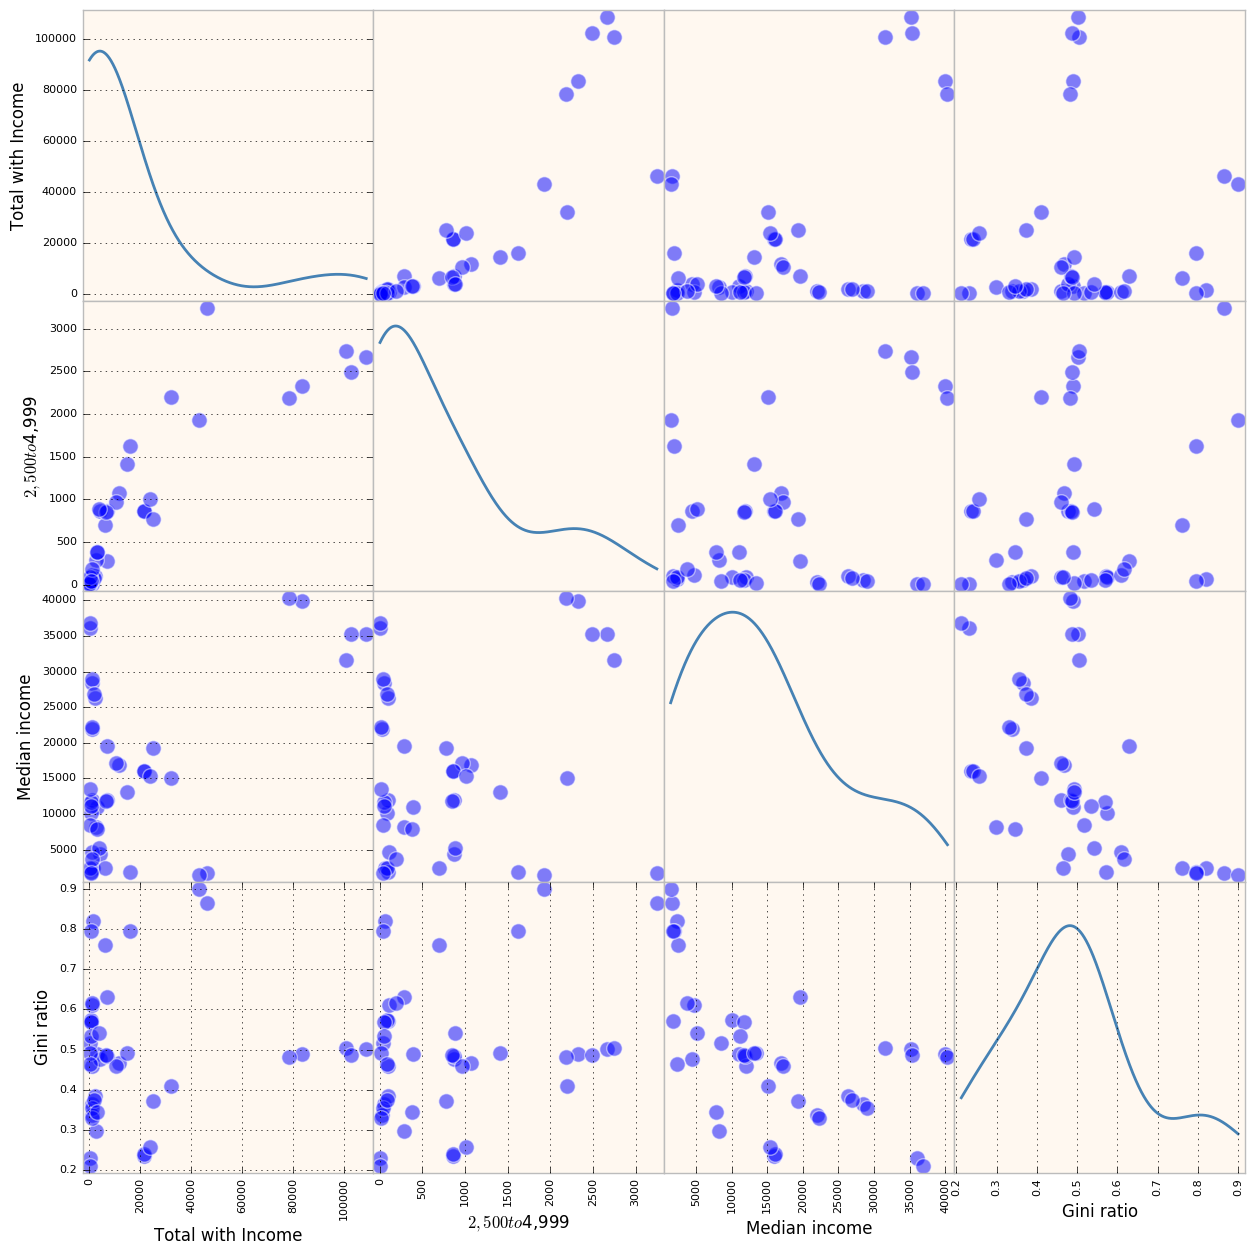

In [38]:
#Plot Scatter matrix for allmales

malesScatterMatrix = pd.scatter_matrix(allmales['all']
                   [['Total with Income', u'$2,500 to $4,999', 'Median income', 'Gini ratio']],
                   alpha=0.5, s=500, figsize=(15, 15), diagonal='kde')

# FBB missing caption

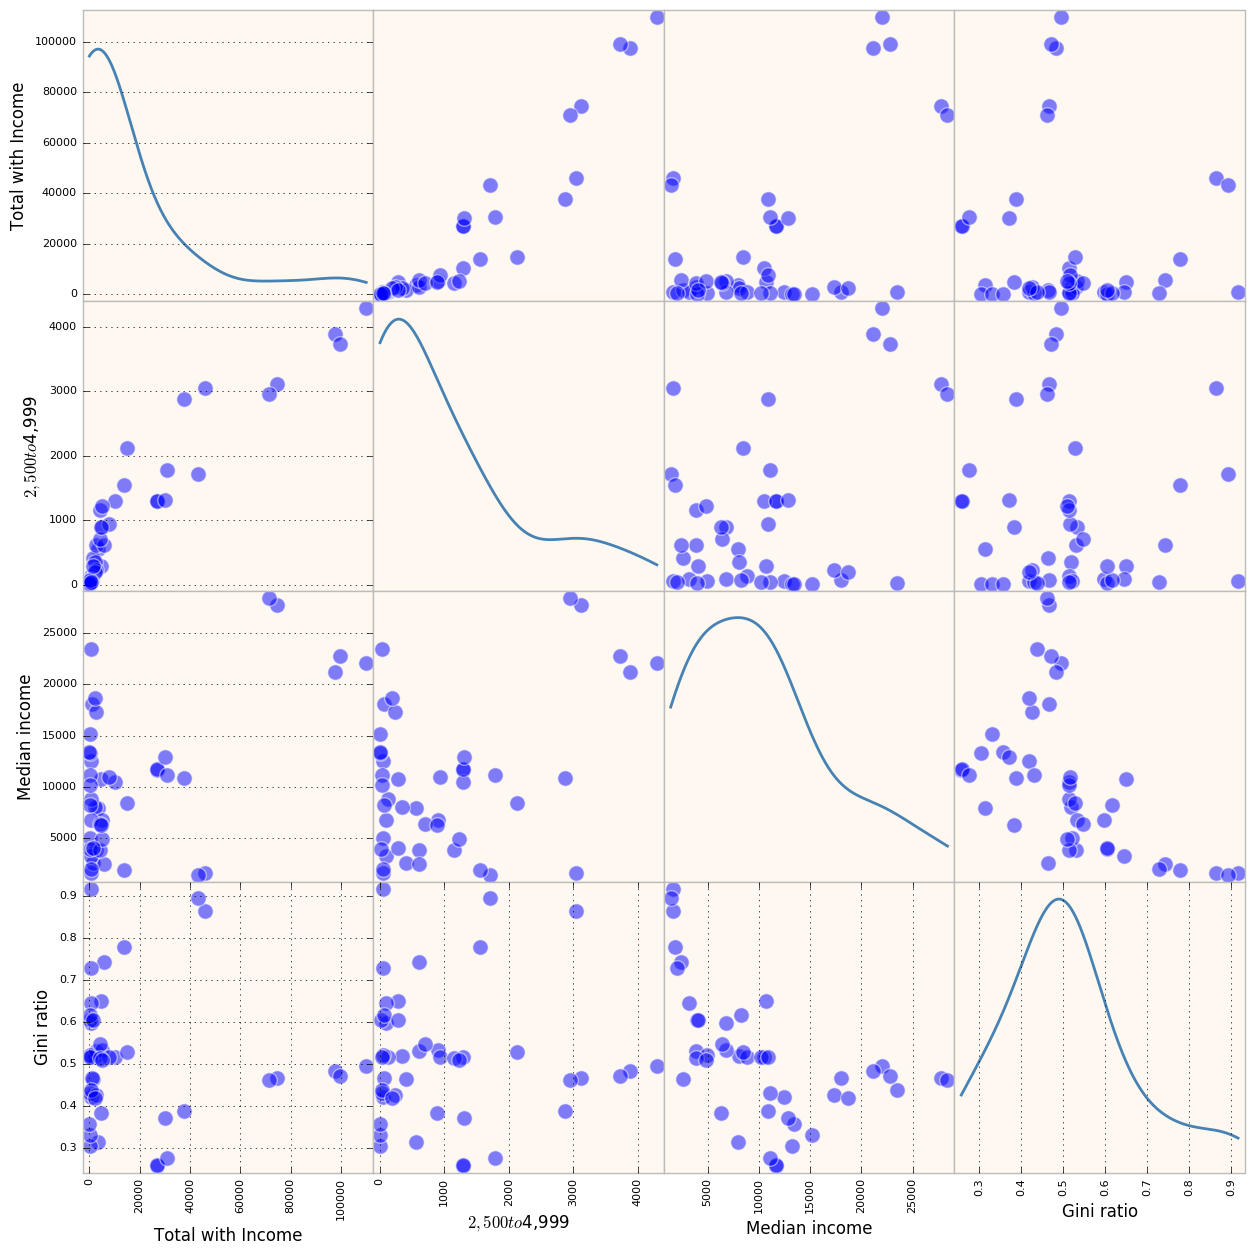

In [40]:
#Plot Scatter Matrix for all Females

malesScatterMatrix = pd.scatter_matrix(allfemales['all']
                   [['Total with Income', u'$2,500 to $4,999', 'Median income', 'Gini ratio']],
                   alpha=0.5, s=500, figsize=(15, 15), diagonal='kde')

# FBB missing caption

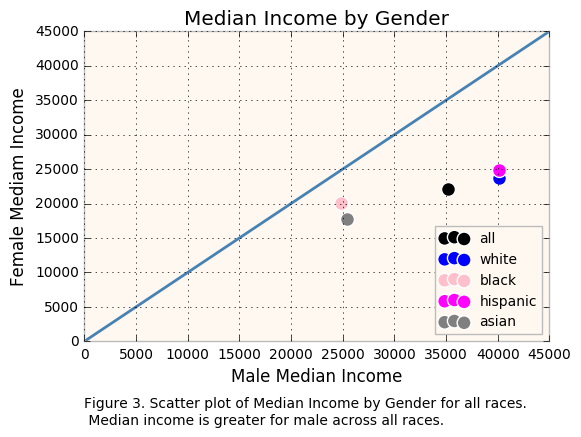

In [385]:
# plotting the Total median income by race
# Total Median Income (from any source of revenue) of females vs the Total Median Income of males, race by race 

races = ['all','white','black','hispanic','asian']
colors = ['black','blue','pink','magenta', 'gray']

pl.axis([0, 45000, 0, 45000])
pl.ylabel("Female Mediam Income")
pl.xlabel("Male Median Income")
    
for i in range (5):
    pl.scatter(allmales[races[i]]['Median income'][1],allfemales[races[i]]['Median income'][1] \
               , s=100, c=colors[i], marker='o', label = races[i])

pl.plot([0, 45000], [0, 45000])
pl.legend(loc="lower right")
pl.title('Median Income by Gender')
pl.size=20,20
pl.text(0, -12000, "Figure 3. Scatter plot of Median Income by Gender for all races. \n \
Median income is greater for male across all races.")

# FBB what shows that the median income is greater for males? Its the equality line, which you should describe in the caption.
# FBB "Scatter plot of Median Income for female and male gender (female vs mele) by ethnic group. The x=y line representing income equality is also plotted. Median income is greater for males across all races"

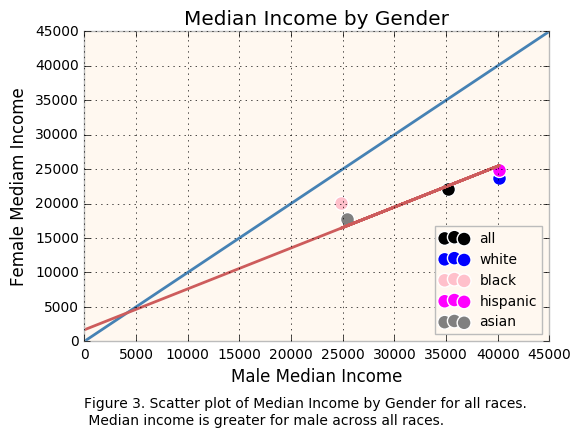

In [281]:
# Fitting our data with a line
# Will use scipy
   
all_males=np.array([0.]+[allmales[k]['Median income'][1] \
                    for k in ['all', 'white', 'black',
                                     'hispanic','asian']])

all_females=np.array([0.]+[allfemales[k]['Median income'][1] \
                             for k in ['all', 'white', 'black',
                                     'hispanic','asian']])

#Using np.p
m, b = np.polyfit(all_males,all_females,1)

pl.axis([0, 45000, 0, 45000])
pl.ylabel("Female Mediam Income")
pl.xlabel("Male Median Income")
   
for i in range (5):
    pl.scatter(allmales[races[i]]['Median income'][1],allfemales[races[i]]['Median income'][1] \
               , s=100, c=colors[i], marker='o', label = races[i])

pl.plot([0, 45000], [0, 45000])
pl.plot(all_males, m * all_males + b, '-')
pl.legend(loc="lower right")
pl.title('Median Income by Gender')
pl.text(0, -12000, "Figure 3. Scatter plot of Median Income by Gender for all races. \n \
Median income is greater for male across all races.")

# FBB you need to describe what you are plotting in the figure captions! This is not the same figure as the previous one, it should not have the same caption!

In [249]:
#(remember: a line is y = beta0 + beta1 * x)


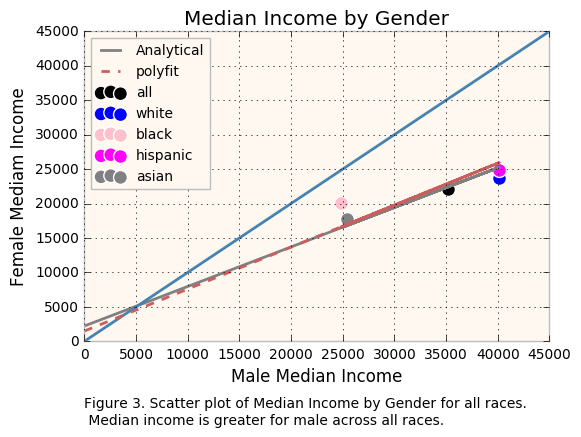

In [347]:
# From the original FBB notebook
# this contains the analytical best regression line. 
# will do my fit and compare with the analytical

#http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
cor = stats.spearmanr(all_males, all_females)
beta1 = cor[0] * all_females.std() / all_males.std()
beta0 = all_females.mean() - beta1 * all_males.mean()
beta0, beta1

# With beta0 and beta1 we can predict female incomes using the analytical model
all_femalesprediction = beta0 + all_males * beta1

pl.axis([0, 45000, 0, 45000])
pl.ylabel("Female Mediam Income")
pl.xlabel("Male Median Income")

for i in range (5):
    pl.scatter(allmales[races[i]]['Median income'][1],allfemales[races[i]]['Median income'][1] \
               , s=100, c=colors[i], marker='o', label = races[i])
pl.plot(all_males, all_femalesprediction, color = 'gray', linestyle = '-', linewidth = 2,label = 'Analytical')
pl.plot([0, 45000], [0, 45000])
pl.plot(all_males, m * all_males + b, '--', label = 'polyfit')
pl.legend(loc="upper left")
pl.title('Median Income by Gender')
pl.text(0, -12000, "Figure 3. Scatter plot of Median Income by Gender for all races. \n \
Median income is greater for male across all races.")

# FBB you should describe the two fits

In [291]:
#Fitting and plotting now with all forms of income

all_males_allincomes = np.array(
    np.concatenate([allmales[k]['Median income'][:].values \
                    for k in ['all',
                                   'white', 'black', 
                                    'hispanic', 'asian']]).flatten())

all_females_allincomes = np.array(
    np.concatenate([allfemales[k]['Median income'][:].values \
                    for k in ['all',
                                   'white', 'black', 
                                    'hispanic', 'asian']]).flatten())

#From FBB Notebook: In case we may need to remove NaN values 

mask = ~(np.isnan(all_males_allincomes) + np.isnan(all_females_allincomes))
# now you can use mask as an index (broadcasting) to select the non NaN values
mask
len(all_males_allincomes)

245

In [339]:
#Prepare the data into a pandas dataframe
males = [0]
females = [0]

for i in arange(len(all_males_allincomes)):
    if mask[i] == True:
        males.append(all_males_allincomes[i])
        females.append(all_females_allincomes[i])

df = pd.DataFrame([males,females]).T
df.columns = ['males','females']

df.head()

,males,females
0,0.0,0.0
1,35228.0,22063.0
2,39903.0,27736.0
3,40298.0,28402.0
4,19557.0,10732.0


In [332]:
prediction = smf.ols(formula = 'females ~ males', data = df).fit()
print (prediction.params)
print (prediction.rsquared)


Intercept    1470.993894
males           0.609942
dtype: float64
0.860609191064


In [340]:
df['femalesprediction'] = (df.males)*prediction.params[1]+prediction.params[0]
df['femalespredictno_intercept'] = (df.males)*prediction.params[1]
df.head()

,males,females,femalesprediction,femalespredictno_intercept
0,0.0,0.0,1470.993894,0.000000
1,35228.0,22063.0,22958.031018,21487.037124
2,39903.0,27736.0,25809.509915,24338.516020
3,40298.0,28402.0,26050.437008,24579.443114
4,19557.0,10732.0,13399.629781,11928.635887


In [344]:
# Fitting previous Anlytical Model

cor = stats.spearmanr(all_males_allincomes[mask], all_females_allincomes[mask])
beta1 = cor[0] * all_females_allincomes[mask].std() / all_males_allincomes[mask].std()
beta0 = all_females_allincomes[mask].mean() - beta1 * all_males_allincomes[mask].mean()
print (beta0, beta1)

# With beta0 and beta1 we can predict female incomes using the analytical model
all_females_allIncome_prediction = beta0 + all_males_allincomes[mask] * beta1

(1293.7640487731387, 0.62234483903975324)


In [346]:
# Fitting previous np.ppolyfit
m, b = np.polyfit(all_males_allincomes[mask],all_females_allincomes[mask],1)
print (m,b)

(0.60902052361748849, 1493.0394411446387)


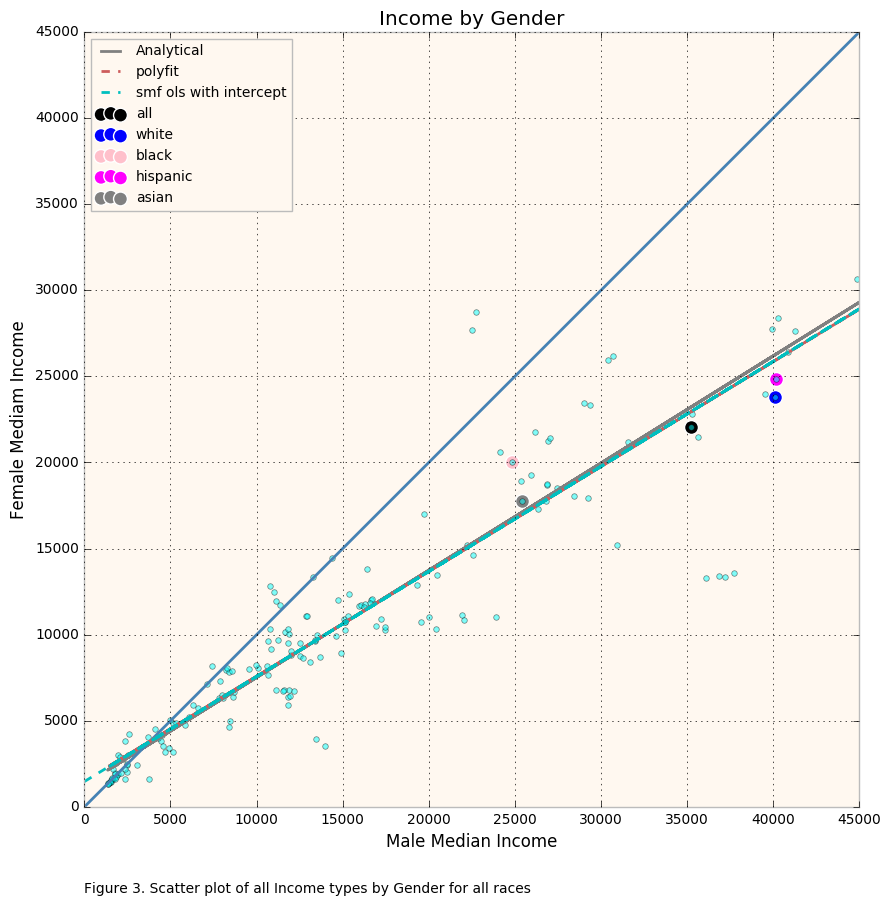

In [353]:
#Plotting all 

pl.figure(figsize = (10,10))
pl.axis([0, 45000, 0, 45000])
pl.ylabel("Female Mediam Income")
pl.xlabel("Male Median Income")

for index in arange(len(all_males_allincomes)):
    if mask[index] == True:
        pl.plot(all_males_allincomes[index], all_females_allincomes[index], 'o', ms = 4, alpha = .5, color='cyan')
   
for i in range (5):
    pl.scatter(allmales[races[i]]['Median income'][1],allfemales[races[i]]['Median income'][1] \
               , s=100, c=colors[i], marker='o', label = races[i])
pl.plot(all_males_allincomes[mask], all_females_allIncome_prediction, color = 'gray', \
        linestyle = '-', linewidth = 2,label = 'Analytical')
pl.plot([0, 45000], [0, 45000])
pl.plot(all_males_allincomes[mask], m * all_males_allincomes[mask] + b, '--', label = 'polyfit')
pl.plot(df.males,df.femalesprediction, color = 'c', linestyle = '--',\
        linewidth = 2, label = 'smf ols with intercept')
pl.legend(loc="upper left")
pl.title('Income by Gender')
pl.text(0, -5000, "Figure 3. Scatter plot of all Income types by Gender for all races")

# FBB captions must describe the elements in the plot and guide the interpretation!

In [382]:
#Prediction with a stipend of 150000

print('A woman in a position where a man recieves U$ 150K a year will receive only ' + str(beta0 + beta1 * 150000))


A woman in a position where a man recieves U$ 150K a year will receive only 88316.6045292


##### The graph paints  picture of racial and gender income inequality (something that unfortunately doesnt suprise me)  it will be interesting to try to refine this analysis by moving beyond the pure financial comparission, maybe bringing elements such as the type of jobs performed or the eduaction level, so we can flag things such as plain discrimination (groups  with equal education or respobilities that are being systematically paid less)


# FBB  that is true, but ethnicity is covariant with income, which  invalidate the first part of the analysis and may invalidate the second the analysis (see my solution)

